Q_1

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

X_train_torch = trainset.data
Y_train_torch = trainset.targets

X_test_torch = testset.data
Y_test_torch = testset.targets



# Training Images:
X_train = X_train_torch.numpy()
# Training Labels:
Y_train = Y_train_torch.numpy()

# Test Images:
X_test = X_test_torch.numpy()
# Test Labels:
Y_test = Y_test_torch.numpy()

In [5]:
# Binarize the data by applying a threshold
threshold = 128  # Pixel values above 128 will be set to 1, others to 0
x_train_binary = (X_train > threshold).astype(np.uint32)
x_test_binary = (X_test > threshold).astype(np.uint32)
x_train_binary = x_train_binary.reshape(-1, 28 * 28)
x_test_binary = x_test_binary.reshape(-1, 28 * 28)

In [6]:
# Display a few samples from the binary dataset
def show_samples(samples, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        # Reshape each sample back to (28, 28) for display
        ax.imshow(samples[i].reshape(28, 28), cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

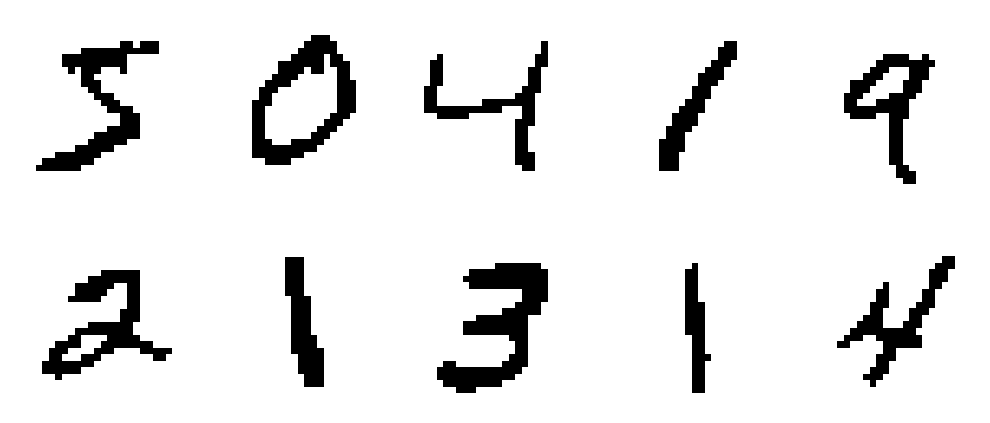

In [7]:
show_samples(x_train_binary[:10])

Q_2

In [11]:
class RBM:
    def __init__(self, n_visible, n_hidden):
      self.n_visible = n_visible
      self.n_hidden = n_hidden
      self.W = np.random.normal(0, 0.01, (n_visible, n_hidden))  # Gaussian init
      self.v_bias = np.zeros(n_visible)
      self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.rand(*prob.shape) < prob).astype(np.float32)

    def gibbs_sampling(self, v, k):
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v = self.sample(v_prob)
        return v

    def contrastive_divergence(self, v, k, lr):
      # Positive phase
      h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)  # Hidden probabilities for input v
      h_sample_0 = self.sample(h_prob_0)  # Sample hidden states

      # Perform k-step Gibbs sampling
      v_neg = v.copy()  # Start with the initial visible states
      for _ in range(k):
          h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)  # Hidden probabilities
          h_sample = self.sample(h_prob)  # Sample hidden states
          v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)  # Visible probabilities
          v_neg = self.sample(v_prob_neg)  # Sample visible states

      # Negative phase
      h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)  # Hidden probabilities for reconstructed v

      # Compute gradients using matrix calculations
      positive_grad = np.dot(v.T, h_prob_0)  # Positive phase gradient
      negative_grad = np.dot(v_neg.T, h_prob_neg)  # Negative phase gradient

      # Update weights and biases
      self.W += lr * (positive_grad - negative_grad) / v.shape[0]
      self.v_bias += lr * np.mean(v - v_neg, axis=0)  # Visible bias update
      self.h_bias += lr * np.mean(h_prob_0 - h_prob_neg, axis=0)  # Hidden bias update

      # Return the final reconstructed visible states
      return v_neg



    def train(self, data, epochs=10, k=1, lr=0.01, batch_size=64):
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                v_neg = self.contrastive_divergence(batch, k, lr)
                epoch_loss += np.mean((batch - v_neg) ** 2)  # Reconstruction loss
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data):.4f}")

    def generate_samples(self, n_samples=10, k=1):
        samples = np.random.rand(n_samples, self.n_visible)
        samples = self.gibbs_sampling(samples, k)
        return samples

In [12]:
# Initialize and train RBM for different values of k
n_visible = x_train_binary.shape[1]
n_hidden = 128
k_values = [1, 5, 10]
rbms = {}

for k in k_values:
    print(f"Training RBM with k={k}")
    rbm = RBM(n_visible, n_hidden)
    rbm.train(x_train_binary, epochs=5, k=10, lr=0.01, batch_size=128)
    rbms[k] = rbm

Training RBM with k=1
Epoch 1/5, Loss: 0.0019
Epoch 2/5, Loss: 0.0013
Epoch 3/5, Loss: 0.0011
Epoch 4/5, Loss: 0.0011
Epoch 5/5, Loss: 0.0010
Training RBM with k=3
Epoch 1/5, Loss: 0.0019
Epoch 2/5, Loss: 0.0013
Epoch 3/5, Loss: 0.0011
Epoch 4/5, Loss: 0.0011
Epoch 5/5, Loss: 0.0010
Training RBM with k=5
Epoch 1/5, Loss: 0.0019
Epoch 2/5, Loss: 0.0013
Epoch 3/5, Loss: 0.0011
Epoch 4/5, Loss: 0.0011
Epoch 5/5, Loss: 0.0010


In [13]:
# Generate and visualize samples
def show_generated_samples(rbm, k, n_samples=10):
    print(f"Generated samples for k={k}")
    samples = rbm.generate_samples(n_samples, k)
    samples = samples.reshape((-1, 28, 28))
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='binary')
        ax.axis('off')
    plt.show()

Generated samples for k=1


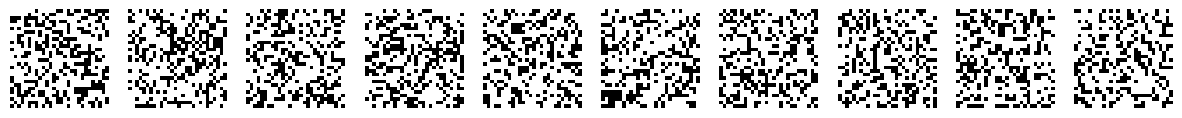

Generated samples for k=3


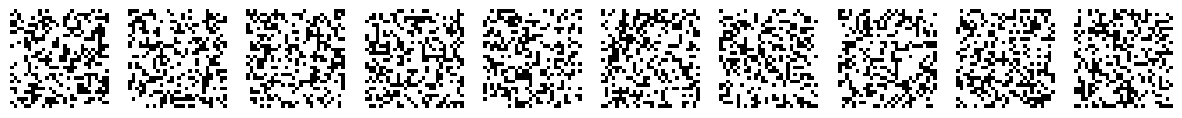

Generated samples for k=5


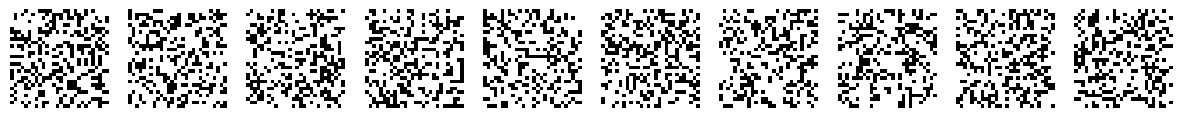

In [14]:
for k in k_values:
    show_generated_samples(rbms[k], k)

Q_3

In [ ]:
def visualize_mcmc_process(rbm, n_samples=5, k=5):
    """
    Visualize the MCMC process in RBM (v_0, v_1, ..., v_k).
    """
    samples = np.random.rand(n_samples, rbm.n_visible)  # Random initialization
    process = [samples]  # Store intermediate states

    # Perform Gibbs sampling for k steps and store each step
    for _ in range(k):
        h_prob = rbm.sigmoid(np.dot(samples, rbm.W) + rbm.h_bias)
        h_sample = rbm.sample(h_prob)
        v_prob = rbm.sigmoid(np.dot(h_sample, rbm.W.T) + rbm.v_bias)
        samples = rbm.sample(v_prob)
        process.append(samples)

    # Visualize the process for each sample
    fig, axes = plt.subplots(n_samples, k + 1, figsize=(15, n_samples * 2))
    for i in range(n_samples):
        for j in range(k + 1):
            ax = axes[i, j] if n_samples > 1 else axes[j]
            ax.imshow(process[j][i].reshape(28, 28), cmap='binary')
            ax.axis('off')
            if i == 0:
                ax.set_title(f"v_{j}", fontsize=10)
    plt.tight_layout()
    plt.show()

# Visualize the MCMC process for k=5 with the trained RBM (k=1)
visualize_mcmc_process(rbms[1], n_samples=5, k=5)

Q_4

In [ ]:
class ConditionalRBM(RBM):
    def __init__(self, n_visible, n_hidden, n_classes):
        super().__init__(n_visible + n_classes, n_hidden)
        self.n_classes = n_classes

    def train(self, data, labels, epochs=10, k=1, lr=0.01, batch_size=64):
        data_with_labels = np.hstack([data, labels])  # Append class labels
        super().train(data_with_labels, epochs, k, lr, batch_size)

    def generate_samples(self, target_label, n_samples=10, k=1):
        # Initialize samples and set target label
        samples = np.random.rand(n_samples, self.n_visible)
        labels = np.zeros((n_samples, self.n_classes))
        labels[np.arange(n_samples), target_label] = 1
        samples_with_labels = np.hstack([samples, labels])

        # Perform Gibbs sampling
        generated = self.gibbs_sampling(samples_with_labels, k)
        return generated[:, :-self.n_classes]  # Return only the visible units

# Prepare one-hot encoded labels
n_classes = 10
y_train_one_hot = np.eye(n_classes)[y_train]  # Convert labels to one-hot

# Train a conditional RBM
conditional_rbm = ConditionalRBM(n_visible, n_hidden, n_classes)
print("Training Conditional RBM...")
conditional_rbm.train(x_train, y_train_one_hot, epochs=5, k=1, lr=0.01, batch_size=64)

# Generate samples for specific digits
target_digits = [0, 1]  # Digits to generate
for digit in target_digits:
    print(f"Generated samples for digit {digit}:")
    generated_samples = conditional_rbm.generate_samples(target_label=digit, n_samples=5, k=5)
    generated_samples = generated_samples.reshape((-1, 28, 28))
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(generated_samples[i], cmap='binary')
        ax.axis('off')
    plt.show()